## Import the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM,Bidirectional,Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

## Load the data

In [2]:
train=pd.read_csv('/content/train.txt',names=["text","emotions"],sep=';')
test=pd.read_csv('/content/test.txt',names=["text","emotions"],sep=';')
val=pd.read_csv("/content/val.txt",names=["text","emotions"],sep=';')

In [3]:
display(train.sample(2))
display(test.sample(2))
display(val.sample(2))

,text,emotions
2511,i was feeling strong and ready,joy
630,i feel is that i cant get far enough away from...,sadness


,text,emotions
1466,i feel that this experience has convinced me a...,joy
1778,i feel a bit lonely just writing this because ...,sadness


,text,emotions
1435,i tend to feel like my stove runs hot so i am ...,love
1948,im just feeling so dazed everyday,surprise


In [4]:
print(f"The shape of train data is {train.shape}")
print(f"The shape of test data is {test.shape}")
print(f"The shape of val data is {val.shape}")

The shape of train data is (16000, 2)
The shape of test data is (2000, 2)
The shape of val data is (2000, 2)


## Exploratory Data Analysis

In [5]:
def class_count(df):
  emotions=df["emotions"].value_counts()
  print(emotions)

  plt.figure(figsize=(10,5))
  sns.barplot(x=emotions.index,y=emotions.values,palette="rocket")
  plt.title("Emotions Count")
  plt.show()


emotions
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64


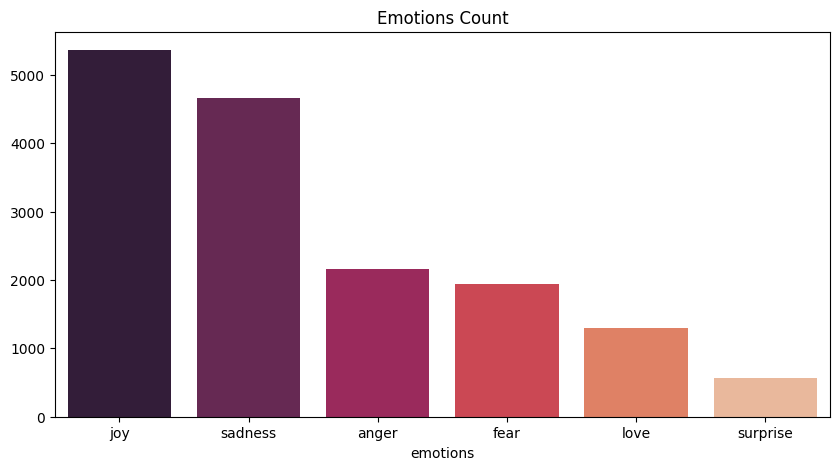

In [6]:
class_count(train)

As you can see the data is highly imbalanced. Joy is the most common emotion, followed by sadness, while surprise is the least common.

emotions
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64


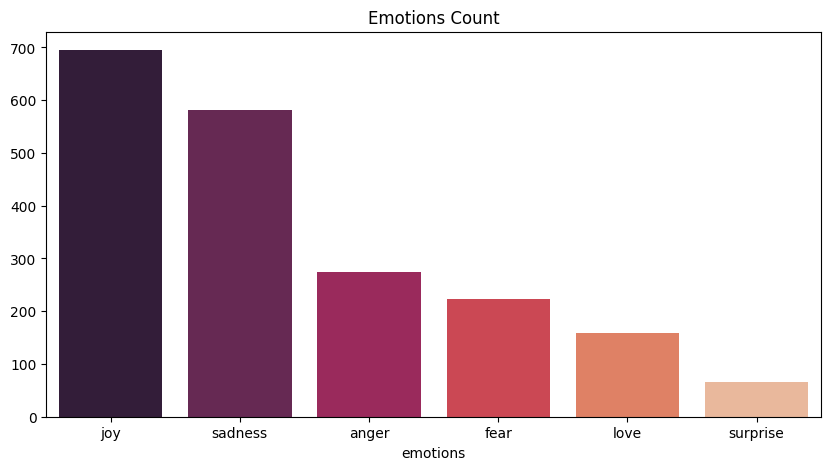

In [7]:
class_count(test)

emotions
joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: count, dtype: int64


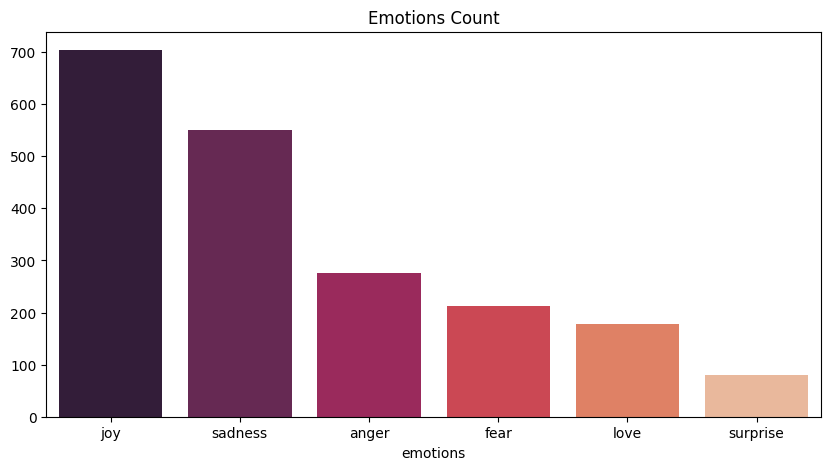

In [8]:
class_count(val)

Same with the test and validation data.

In [9]:
text_count = 0
for text in train['text']:
    if len(text.split())<60:
        text_count += 1
print(text_count/len(train['text']))

0.998875


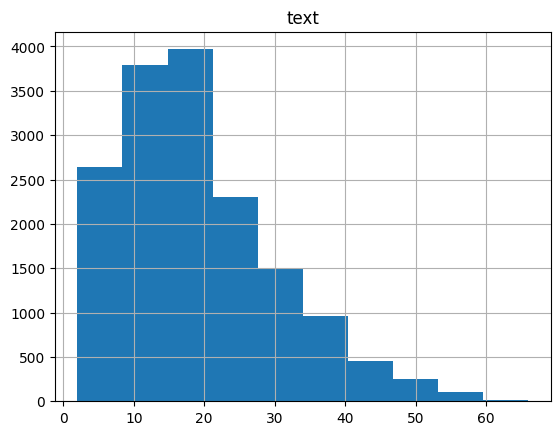

In [10]:
text_word_count = []

# get number of words in text

for i in train['text']:
    text_word_count.append(len(i.split()))

length = pd.DataFrame()
length['text'] = pd.Series(text_word_count)

length.hist()
plt.show()

From the graph, it is clear that almost 99% of the texts have fewer than 60 words.

## preprocessing

In [11]:
import re

def clean_text(text):
    text = text.lower()                              # Lowercase
    text = re.sub(r"[^a-zA-Z\s]", "", text)          # Remove punctuation/numbers
    text = re.sub(r"\s+", " ", text).strip()         # Remove extra spaces
    return text

The `clean_text` function cleans input text by converting it to lowercase, removing all punctuation and numbers, and trimming extra spaces.

In [12]:
train["text"]=train["text"].apply(clean_text)
test["text"]=test["text"].apply(clean_text)
val["text"]=val["text"].apply(clean_text)

## Tokenization and Padding

Tokenization breaks text into smaller units like words or subwords so models can understand them. Padding makes all input sequences the same length for efficient batch processing in models

In [13]:
# Tokenization
tokenizer = Tokenizer(num_words=5000) # Vocabulary size
tokenizer.fit_on_texts(train['text'])

train_sequences = tokenizer.texts_to_sequences(train['text'])
val_sequences = tokenizer.texts_to_sequences(val['text'])

# Padding
max_length = 60  # Maximum sequence length
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding='post', truncating='post')

## Split the data

In [14]:
# Split the data into features (X) and target (y)
X_train = train_padded
y_train = train['emotions']
X_val = val_padded
y_val = val['emotions']


## Encoding Target Labels Using LabelEncoder

In [15]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

The `LabelEncoder` converts categorical emotion labels into numeric form so machine learning models can process them. It fits on the training labels and transforms both training and validation labels consistently.

## Model Buliding and Training

In [19]:
# Enhanced Model Architecture with Regularization
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=256, input_length=max_length)) # Increased embedding dimension
model.add(Bidirectional(LSTM(256, return_sequences=True))) # Increased LSTM units
model.add(Dropout(0.5)) # Increased dropout for regularization

model.add(Bidirectional(LSTM(128))) # Added another Bidirectional LSTM layer
model.add(Dropout(0.5)) # Dropout after the second LSTM layer

model.add(Dense(64, activation='relu')) # Added a dense layer with ReLU activation
model.add(Dropout(0.3)) # Dropout before the output layer

model.add(Dense(6, activation='softmax'))

optimizer = Adam(learning_rate=3e-4) # Slightly increased learning rate
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Training with early stopping and increased epochs
history = model.fit(X_train, y_train,
                    epochs=30,  # Increased epochs
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping]) # Added early stopping



Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.3245 - loss: 1.6190 - val_accuracy: 0.5535 - val_loss: 1.1866
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.6644 - loss: 0.9278 - val_accuracy: 0.8040 - val_loss: 0.5938
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.8484 - loss: 0.4498 - val_accuracy: 0.8620 - val_loss: 0.4107
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9124 - loss: 0.2724 - val_accuracy: 0.8835 - val_loss: 0.3547
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9395 - loss: 0.1795 - val_accuracy: 0.9005 - val_loss: 0.3165
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9557 - loss: 0.1427 - val_accuracy: 0.9075 - val_loss: 0.3277
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9668 - loss: 0.1104 - val_accuracy: 0.9035 - val_loss: 0.3274
Epoch 8/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.9650 - loss: 0.1133 - val

## Model Summary
- Built an enhanced emotion classification model using an LSTM-based neural network.

- Used Bidirectional LSTM layers, dropout regularization, and a dense ReLU layer for deeper feature learning.

- Applied early stopping to avoid overfitting and ensure optimal validation performance.

**Observations**    
- The training accuracy steadily increases while the validation accuracy fluctuates, suggesting potential overfitting despite the use of dropout and early stopping.         
- The model's performance needs further evaluation on unseen test data to confirm generalization ability.      
- Early stopping likely prevented further overfitting, but the gap between training and validation accuracy implies that the model might still be learning noise in the training data.


## Model Evaluation

In [23]:
# Evaluate the model
loss,accuracy = model.evaluate(X_val, y_val)
print(f"Validation accuracy: {accuracy*100:.2f}%")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9108 - loss: 0.3434
Validation accuracy: 90.95%


In [ ]:
# Make predictions on the validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Accuracy: 0.9095
Precision: 0.9091580720487135
Recall: 0.9095
F1 Score: 0.909229145009175


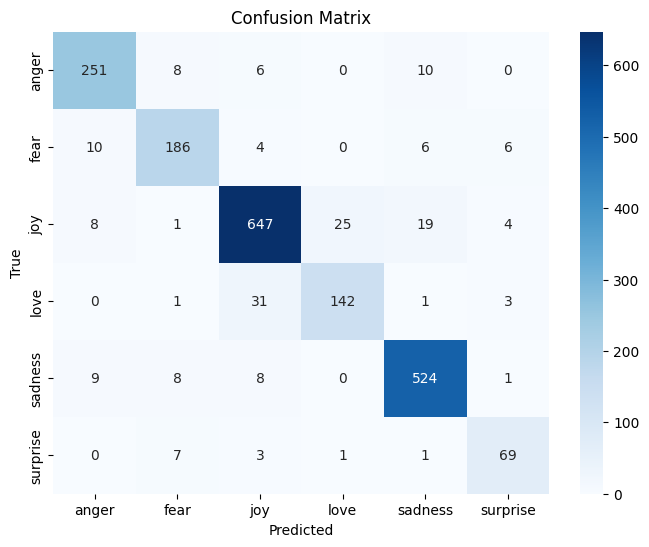

In [20]:
# Calculate metrics
accuracy = accuracy_score(y_val, y_pred_classes)
precision = precision_score(y_val, y_pred_classes, average='weighted')
recall = recall_score(y_val, y_pred_classes, average='weighted')
f1 = f1_score(y_val, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Create confusion matrix
cm = confusion_matrix(y_val, y_pred_classes)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


**Observations**
- The confusion matrix shows misclassifications primarily between 'joy' and 'sadness', and to a lesser extent with other emotions.  
- The accuracy, precision, recall, and F1-score suggest a reasonably good overall performance, but the confusion matrix details where the model struggles.  
- The relatively high accuracy might be misleading due to **class imbalance**.  
- Further investigation into the misclassifications is necessary to improve the model's performance.


## Model Evaluation on Test Data with Performance Metrics and Confusion Matrix

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Test Accuracy: 0.9095
Test Precision: 0.9095903551979636
Test Recall: 0.9095
Test F1 Score: 0.909375190889858


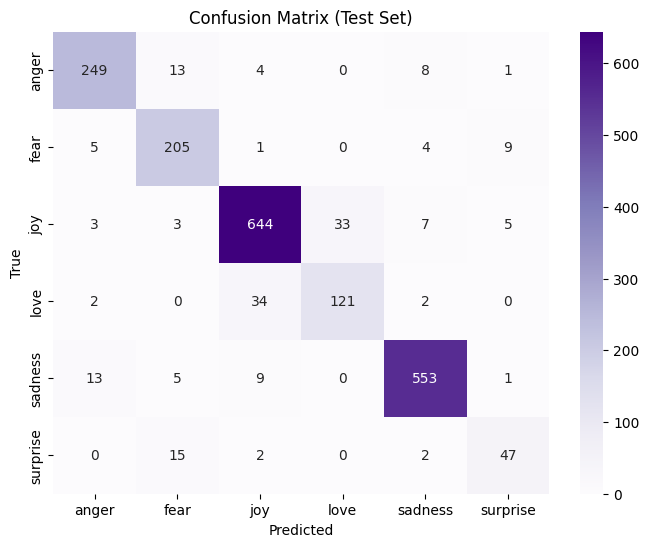

In [28]:
# Preprocess the test data
test_sequences = tokenizer.texts_to_sequences(test['text'])
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

# Make predictions on the test set
y_pred_test = model.predict(test_padded)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)

# Convert the predicted classes back to emotion labels
y_pred_test_labels = le.inverse_transform(y_pred_test_classes)

# Calculate metrics for the test set
y_true_test = le.transform(test['emotions'])  # Encode true labels
accuracy_test = accuracy_score(y_true_test, y_pred_test_classes)
precision_test = precision_score(y_true_test, y_pred_test_classes, average='weighted')
recall_test = recall_score(y_true_test, y_pred_test_classes, average='weighted')
f1_test = f1_score(y_true_test, y_pred_test_classes, average='weighted')

print(f"Test Accuracy: {accuracy_test}")
print(f"Test Precision: {precision_test}")
print(f"Test Recall: {recall_test}")
print(f"Test F1 Score: {f1_test}")

# Create confusion matrix for the test set
cm_test = confusion_matrix(y_true_test, y_pred_test_classes)

# Plot confusion matrix as heatmap for the test set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Purples",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test Set)")
plt.show()


**Observations**

- The model shows moderate performance with room for improvement.  
- While accuracy, precision, recall, and F1-score appear reasonable, the confusion matrix highlights misclassifications, particularly between 'joy' and 'sadness'.  
- Class imbalance may inflate the accuracy metric; a more robust evaluation considering weighted metrics is crucial.  


1.The dataset had a significant class imbalance, where certain emotions like sadness and joy were overrepresented while others had far fewer examples.

2.This imbalance led to biased predictions, with the model favoring majority classes.

3.To address this, [**text generation techniques**](https://github.com/bhanuprakash-321/Sentiment-Analysis-and-Emotion-Conditioned-Text-Generation-Using-Deep-Learning/blob/main/.ipynb%20files/Text_Generation.ipynb) were used to synthetically generate emotion-specific tweets for underrepresented classes, helping to balance the dataset and improve classification performance.